<a href="https://colab.research.google.com/github/sujitpal/nlp-deeplearning-ai-examples/blob/master/x3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Repayment Classifier

Simple Dense network to predict if a credit card customer will pay or default next month, given their attributes and payment history.

Uses the [Default of Credit Card dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) from the UCI Machine Learning Repository.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = "drive/My Drive/nlp-deeplearning-ai-data"

In [ ]:
cc_df = pd.read_csv(os.path.join(DATA_DIR, "UCI_Credit_Card.csv"))
cc_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### Drop Unnecessary Column after Analysis

In [ ]:
cleancc_df = cc_df.drop(columns=["ID", "SEX"])
cleancc_df.shape

(30000, 23)

### Remove Null Values

In [ ]:
total = cleancc_df.isnull().sum()
percent = cleancc_df.isnull().sum() / cleancc_df.isnull().count()
pd.concat([total, percent], axis=1, keys=["TOTAL", "PERCENT"])

,TOTAL,PERCENT
LIMIT_BAL,0,0.0
EDUCATION,0,0.0
MARRIAGE,0,0.0
AGE,0,0.0
PAY_0,0,0.0
PAY_2,0,0.0
PAY_3,0,0.0
PAY_4,0,0.0
PAY_5,0,0.0
PAY_6,0,0.0


### Remove Outliers

In [ ]:
num_rows = len(cleancc_df)
for col in cleancc_df.columns:
  col_values = cleancc_df[col].values
  mean_val, std_val = np.mean(col_values), np.std(col_values)
  col_min, col_max = mean_val - 3 * std_val, mean_val + 3 * std_val
  count = 0
  for col_value in col_values:
    if col_value < col_min or col_value > col_max:
      count += 1
  print("{:s} -> {:.3f}% outliers".format(col, count * 100 / num_rows))

LIMIT_BAL -> 0.433% outliers
EDUCATION -> 1.103% outliers
MARRIAGE -> 0.000% outliers
AGE -> 0.470% outliers
PAY_0 -> 0.470% outliers
PAY_2 -> 0.523% outliers
PAY_3 -> 0.500% outliers
PAY_4 -> 0.563% outliers
PAY_5 -> 0.547% outliers
PAY_6 -> 0.430% outliers
BILL_AMT1 -> 2.287% outliers
BILL_AMT2 -> 2.233% outliers
BILL_AMT3 -> 2.203% outliers
BILL_AMT4 -> 2.267% outliers
BILL_AMT5 -> 2.170% outliers
BILL_AMT6 -> 2.170% outliers
PAY_AMT1 -> 1.300% outliers
PAY_AMT2 -> 1.023% outliers
PAY_AMT3 -> 1.207% outliers
PAY_AMT4 -> 1.320% outliers
PAY_AMT5 -> 1.380% outliers
PAY_AMT6 -> 1.463% outliers
default.payment.next.month -> 0.000% outliers


### Class Imbalance

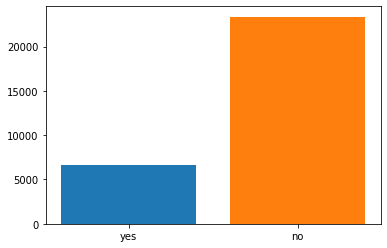

In [ ]:
target = cleancc_df["default.payment.next.month"]
num_yes = target[target==1].count()
num_no = target[target==0].count()

plt.bar("yes", num_yes)
plt.bar("no", num_no)
_ = plt.show()

### Oversampling of Yes class

In [ ]:
cc_yes_df = cleancc_df[cleancc_df["default.payment.next.month"] == 1]
cc_no_df = cleancc_df[cleancc_df["default.payment.next.month"] == 0]

cc_yes_oversampled_df = cc_yes_df.sample(num_no, replace=True, random_state=0)
cleancc_df = pd.concat([cc_no_df, cc_yes_oversampled_df], axis=0)
len(cleancc_df)

46728

### Split X and y

In [ ]:
data_df = cleancc_df.drop(columns=["default.payment.next.month"])
label_df = cleancc_df["default.payment.next.month"]

### Rescale data

In [ ]:
data_df = (data_df - data_df.min()) / (data_df.max() - data_df.min())
data_df.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
2,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,0.172392,0.079532,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,0.188100,0.111995,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,0.154144,0.071601,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284
5,0.040404,0.166667,0.666667,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,0.203506,0.120381,0.117974,0.178407,0.100102,0.276367,0.002862,0.001078,0.000733,0.001610,0.002345,0.001513
6,0.494949,0.166667,0.666667,0.137931,0.2,0.2,0.2,0.2,0.2,0.2,0.472126,0.457242,0.330672,0.671310,0.559578,0.625196,0.062961,0.023749,0.042409,0.032591,0.032237,0.026047


### Split into training, validation and test

In [ ]:
X, y = data_df.values, label_df.values
Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, random_state=0)

Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((29905, 22), (29905,), (7477, 22), (7477,), (9346, 22), (9346,))

### Dataset and DataLoader

In [ ]:
train_ds = TensorDataset(torch.tensor(Xtrain, dtype=torch.float32),
                         torch.tensor(ytrain, dtype=torch.long))
val_ds = TensorDataset(torch.tensor(Xval, dtype=torch.float32),
                       torch.tensor(yval, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(Xtest, dtype=torch.float32),
                        torch.tensor(ytest, dtype=torch.long))

In [ ]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

### Model (using Sequential)

In [ ]:
input_size = 22
hidden_size = 10
output_size = 2

model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size),
    nn.LogSoftmax()
)
print(model)

Sequential(
  (0): Linear(in_features=22, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax()
)


In [ ]:
class ClassifierNet(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(ClassifierNet, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    z = F.relu(self.linear1(x))
    o = F.softmax(self.linear2(z))
    return o

net = ClassifierNet(input_size, hidden_size, output_size)
net

ClassifierNet(
  (linear1): Linear(in_features=22, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

### Training Loop

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net.to(dev)

ClassifierNet(
  (linear1): Linear(in_features=22, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
def evaluate(net, dev, val_dl, criterion):
  dev_loss, dev_acc, dev_totals, dev_correct = 0, 0, 0, 0
  with torch.no_grad():
    for x, y in val_dl:
      x, y = x.to(dev), y.to(dev)
      y_pred = net(x)
      dev_loss += criterion(y_pred, y)
      _, predicted = torch.max(y_pred.data, 1)
      dev_correct += (predicted == y).sum()
      dev_totals += y.size()[0]
    dev_acc = dev_correct.item() / dev_totals
    dev_loss = dev_loss.item() / dev_totals
  return dev_loss, dev_acc


num_epochs = 10
train_losses, dev_losses, train_accs, dev_accs = [], [], [], []
for e in range(num_epochs):

  num_iters = 0
  train_loss, train_acc, train_totals, train_correct = 0, 0, 0, 0

  for x, y in train_dl:
    x, y = x.to(dev), y.to(dev)

    optimizer.zero_grad()

    y_pred = net(x)
    loss = criterion(y_pred, y)
    _, predicted = torch.max(y_pred.data, 1)
    train_correct += (predicted == y).sum()
    train_totals += y.size()[0]
    
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    with torch.no_grad():
      dev_loss, dev_acc = evaluate(net, dev, val_dl, criterion)

    if num_iters % 100 == 0:
      print("... Iteration {:d}, Train loss: {:.3f}, Validation loss: {:.3f}"
        .format(num_iters, train_loss, dev_loss))
      
    num_iters += 1
  
  # save epoch level stats for charting later
  train_acc = train_correct.item() / train_totals
  train_loss = train_loss / train_totals
  print("EPOCH {:d} | train loss: {:.3f}, acc: {:.3f} | validation loss: {:.3f}, acc: {:.3f}"
    .format(e, train_loss, train_acc, dev_loss, dev_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  dev_losses.append(dev_loss)
  dev_accs.append(dev_acc)



... Iteration 0, Train loss: 0.692, Validation loss: 0.005
... Iteration 100, Train loss: 69.594, Validation loss: 0.005
... Iteration 200, Train loss: 136.627, Validation loss: 0.005
EPOCH 0 | train loss: 0.005, acc: 0.600 | validation loss: 0.005, acc: 0.645
... Iteration 0, Train loss: 0.645, Validation loss: 0.005
... Iteration 100, Train loss: 65.611, Validation loss: 0.005
... Iteration 200, Train loss: 129.464, Validation loss: 0.005
EPOCH 1 | train loss: 0.005, acc: 0.655 | validation loss: 0.005, acc: 0.666
... Iteration 0, Train loss: 0.661, Validation loss: 0.005
... Iteration 100, Train loss: 63.565, Validation loss: 0.005
... Iteration 200, Train loss: 126.648, Validation loss: 0.005
EPOCH 2 | train loss: 0.005, acc: 0.668 | validation loss: 0.005, acc: 0.670
... Iteration 0, Train loss: 0.642, Validation loss: 0.005
... Iteration 100, Train loss: 62.773, Validation loss: 0.005
... Iteration 200, Train loss: 125.353, Validation loss: 0.005
EPOCH 3 | train loss: 0.005, acc:

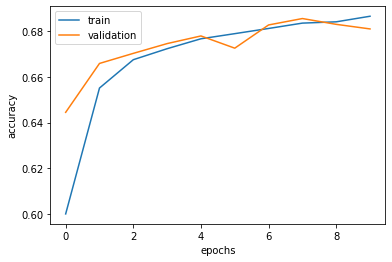

In [ ]:
plt.plot(train_accs, label="train")
plt.plot(dev_accs, label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
_ = plt.show()

### Save Model

In [ ]:
checkpoint = {
    "input": input_size,
    "hidden": hidden_size,
    "output": output_size,
    "state_dict": net.state_dict()
}
torch.save(checkpoint, os.path.join(DATA_DIR, "model_c3.ptb"))

### Load Model

In [ ]:
checkpoint = torch.load(os.path.join(DATA_DIR, "model_c3.ptb"))
new_net = ClassifierNet(checkpoint["input"], checkpoint["hidden"], checkpoint["output"])
new_net.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

### Predictions

In [ ]:
criterion = nn.CrossEntropyLoss()
new_net.to(dev)
test_loss, test_acc = evaluate(new_net, dev, test_dl, criterion)
test_loss, test_acc

(0.004813583050757844, 0.6906698052642842)

In [ ]:
with torch.no_grad():
  for x, y in test_dl:
    x, y = x.to(dev), y.to(dev)
    output = net(x)
    _, y_pred = torch.max(output.data, 1)
    break

for i in range(10):
  labels = y.cpu().numpy()
  predictions = y_pred.cpu().numpy()
  if i < 10:
    print(labels[i], predictions[i])


0 1
1 1
1 1
0 0
0 0
1 1
1 0
0 0
1 1
1 0
